In [2]:
!which python

/anaconda3/bin/python


In [3]:
import sys

In [4]:
sys.path.append("/Users/aaron/Documents/github/ssdmultibox/venv/lib/python3.6/site-packages/")

In [5]:
import torch

In [11]:
import enum
import time

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from ssdmultibox.criterion import SSDLoss
from ssdmultibox.datasets import PascalDataset, TrainPascalDataset, ValPascalDataset, device
from ssdmultibox.models import SSDModel

EPOCHS = 1
BATCH = 4
NUM_WORKERS = 0 # MAC: sysctl -n hw.ncpu
LR = 0.01


class Phase(enum.Enum):
    TRAIN = 'TRAIN'
    VAL = 'VAL'


# if 'losses' not in locals():
losses = {
    Phase.TRAIN: {'total':[], 'loc':[], 'conf':[]},
    Phase.VAL: {'total':[], 'loc':[], 'conf':[]}
}


def get_dataloaders(batch=BATCH, num_workers=NUM_WORKERS):
    train_dataset = TrainPascalDataset()
    val_dataset = ValPascalDataset()
    return {
        Phase.TRAIN: DataLoader(
            train_dataset, batch_size=batch, num_workers=num_workers, shuffle=True),
        Phase.VAL: DataLoader(
            val_dataset, batch_size=batch, num_workers=num_workers)
    }


def get_model():
    return SSDModel().to(device)


model = get_model()
dataloaders = get_dataloaders()
epochs = 1
lr = LR

criterion = SSDLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
current_time = time.time()

for epoch in range(epochs):
    scheduler.step()
    for phase in [Phase.TRAIN, Phase.VAL]:
        dataloader = dataloaders[phase]
        if phase == Phase.TRAIN:
            model.train()
        else:
            model.eval()

        for i, (image_ids, ims, gt_bbs, gt_cats) in enumerate(dataloader):
            # put data on device
            ims, gt_bbs, gt_cats = PascalDataset.to_device(ims, gt_bbs, gt_cats)

            # zero out gradients
            optimizer.zero_grad()

            # forward pass
            with torch.set_grad_enabled(phase == Phase.TRAIN):
                preds = model(ims)
                loss, loc_loss, conf_loss = criterion(preds, (gt_bbs, gt_cats))

                # backward pass
                if phase == Phase.TRAIN:
                    loss.backward()
                    optimizer.step()

                # stats
                if i % 5 == 0:
                    print(i, 'loss:', loss.item(), 'time:', time.time() - current_time)
                    current_time = time.time()
                    losses[phase]['total'].append(loss.item())
                    losses[phase]['loc'].append(loc_loss.item())
                    losses[phase]['conf'].append(conf_loss.item())
                break
        break
    break

bbs_loss: 54.13208770751953
cats_loss: 825.8751831054688
0 loss: 3.188432216644287 time: 11.244524002075195


In [12]:
loss, loc_loss, conf_loss

(tensor(3.1884, grad_fn=<ThMulBackward>),
 tensor(54.1321, grad_fn=<ThAddBackward>),
 tensor(825.8752, grad_fn=<ThAddBackward>))

In [13]:
losses

{<Phase.TRAIN: 'TRAIN'>: {'total': [3.188432216644287],
  'loc': [54.13208770751953],
  'conf': [825.8751831054688]},
 <Phase.VAL: 'VAL'>: {'total': [], 'loc': [], 'conf': []}}

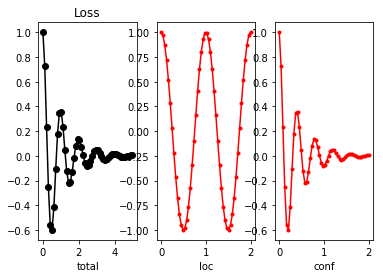

In [36]:
import numpy as np
import matplotlib.pyplot as plt


x1 = np.linspace(0.0, 5.0)
x2 = np.linspace(0.0, 2.0)

y1 = np.cos(2 * np.pi * x1) * np.exp(-x1)
y2 = np.cos(2 * np.pi * x2)

plt.subplot(1, 3, 1)
plt.plot(x1, y1, 'ko-')
plt.title('Loss')
plt.xlabel('total')

plt.subplot(1, 3, 2)
plt.plot(x2, y2, 'r.-')
plt.xlabel('loc')

plt.subplot(1, 3, 3)
plt.plot(x2, y1, 'r.-')
plt.xlabel('conf')


plt.show()

In [ ]:
plt.subplot()